In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import colorsys
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
prev_time = 0
gamma = 0.99
stats = {}  # tracks ewma running average
def benchmark(point=None, profile=True): # not thread safe at all
    global prev_time
    if not profile:
        return
    if point is not None:
        time_taken = time.perf_counter() - prev_time
        if point not in stats:
            stats[point] = time_taken
        stats[point] = stats[point]*gamma + time_taken*(1-gamma)
        print(f"took {time_taken} to reach {point}, ewma={stats[point]}")
    prev_time = time.perf_counter()

In [39]:
class ColorDatasetGenerator(Dataset):
    def __init__(self, **kwargs):
        # define default values for parameters, can override any using kwargs
        # noise parameters
        self.num_noise = (50, 70)  # number of locations to generate noise at
        self.noise_size = (5, 10)  # size that each noise instance can be

        # image parameters
        self.size = 256 # shape of image
        self.channels = 1  # default is greyscale
        self.bg_color = 0  # must have same number of channels 

        # target parameters
        self.color_classifier = None  # function that maps colors to classes (supports iterables)
        self.num_classes = 2  # how many possible classes there are
        # greyscale
        self.color_range = (50, 200)  # range of values that the greyscale color-to-be-classified can be
        # RGB (which we generate as HSV for simplicity)
        self.value_range = (20, 100) # range for value in HSV (subset of (0, 100))
        self.saturation_range = (20, 100) # range for saturation in HSV (subset of (0, 100))
        self.hue_range = (0, 360)  # range for hue in HSV (subset of (0, 360))
    
        self.radius = (self.size//6, self.size//3)  # range of possible radii for circles
        self.num_objects = 1 # supports ranges, if want multiclass

        # actual dataset
        #self.labels = {}  # {filename: label} mapping
        self.image_indices = (0, 1_000_00)   # range of np.random.seeds for the given dataset
        self.options = []  # list of dataset options that need to be saved
        # self.save_dir = ""   # location for all images to be stored
        for k,v in kwargs.items():
            setattr(self, k, v)
            self.options.append(k)
            
    def iterative_color_cvt(self, conversion, iterable):
        # iterates over first dimension
        convert_func = getattr(colorsys, conversion)
        return np.array(list(map(lambda x: convert_func(*x), iterable)))
        
    def generate_colors(self, amt):
        if self.channels == 1: # greyscale
            color = np.random.randint(*self.color_range, (amt))
        else:  # rgb
            hue = np.random.randint(*self.hue_range, (amt))/360
            saturation = np.random.randint(*self.saturation_range, (amt))/100
            value = np.random.randint(*self.value_range, (amt))/100
            color = (self.iterative_color_cvt("hsv_to_rgb", zip(hue, saturation, value))*255.).round() 
        return color

    def add_target(self, arr, set_color):
        num_objects = self.num_objects # np.random.randint(*self.num_objects)
        
        if set_color is not None:
            color = np.array([set_color]*num_objects)
        else:
            color = self.generate_colors(num_objects)

        label = np.zeros((self.num_classes))
        label[self.color_classifier(color)] = 1  # multi-hot encoded
        if self.num_classes == 2:
            label = np.expand_dims(label[0], 0)

        # probably should make sure they dont overlap too much, but num_objects=1 for now
        #img_name = "img"
        radii = np.random.randint(*self.radius, (num_objects))
        locations = np.random.randint(self.radius[1], self.size-self.radius[1], (num_objects, 2))
        for radius, location in zip(radii, locations):
            x_coords = np.arange(radius)
            for x in x_coords:
                height = 2*int(np.sqrt(radius**2 - x**2))
                y_coords = np.arange(height) - height//2 + location[1]
                arr[location[0]+x, y_coords] = color
                arr[location[0]-x, y_coords] = color
            #img_name += f"-{radius}_{location[0]}_{location[1]}"
        #img_name += "".join(random.choice(string.ascii_letters) for _ in range(10)) + ".jpg"
        return label, color  # doesnt really work if we are doing multiclass

    def add_noise(self, arr):
        num_noise = np.random.randint(*self.num_noise)
        sizes = np.random.randint(*self.noise_size, num_noise)
        colors = self.generate_colors(num_noise)
        locations = np.random.randint(self.noise_size[1], self.size-self.noise_size[1], (num_noise, 2))
        for size, color, location in zip(sizes, colors, locations):
            arr[location[0]:location[0]+size,location[1]:location[1]+size] = color

    def generate_one(self, set_color=None, profile=False):
        #benchmark(profile=profile)
        img = np.ones((self.size, self.size, self.channels)) * self.bg_color
        #benchmark("initialization", profile)
        label, color = self.add_target(img, set_color)
        #benchmark("circle", profile)
        self.add_noise(img)
        #benchmark("noise", profile)
        return img, label, color

    # as it turns out, generating data on the fly is faster any way :\
#     def generate_data(self, amount):
#         for _ in tqdm(range(amount)):
#             img, img_name, label = self.generate_one()
#             pil_img = Image.fromarray(np.squeeze(img.astype(np.uint8)), "L")
#             pil_img.save(os.path.join(self.save_dir, img_name))
#             self.labels[img_name] = label
#         # so we dont have to write a custom Sampler
#         self.data = list(self.labels.items())  # (img_name,label) pairs

    def __len__(self):
        return self.image_indices[1] - self.image_indices[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        np.random.seed(idx)  # to make results repeatable
        image, label, color = self.generate_one()
        if hasattr(self, "transform"):
            image = self.transform(image)
        sample = {'image': image, 'label': label, 'color': color}
        return sample

        # sorta pointless now?
#     def save_options(self, path):
#         save_kwargs = {}
#         for opt in self.options:
#             save_kwargs[opt] = getattr(self, opt)
#         with open(path, "wb") as p:
#             pickle.dump(save_kwargs, p)

#     def load_options(self, path):
#         with open(path, "rb") as p:
#             load_kwargs = pickle.load(p)
#         for k,v in load_kwargs.items():
#             setattr(self, k, v)


In [20]:
def color_classifier(color):
    if colorsys.rgb_to_hsv(*(color[0]/255))[0] >= 150:
        return 1
    return 0

In [40]:
color_dataset = ColorDatasetGenerator(color_classifier=color_classifier,
                                     channels=3,
                                     bg_color=np.array([127., 127., 127.]))
color_dataloader = DataLoader(color_dataset, batch_size=4, shuffle=True, 
                              num_workers=4, pin_memory=True)

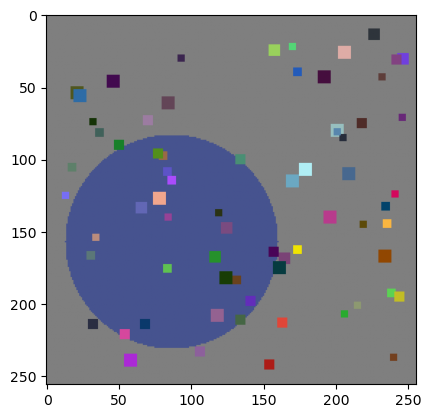

In [41]:
plt.imshow(color_dataset[535]["image"]/255)

5


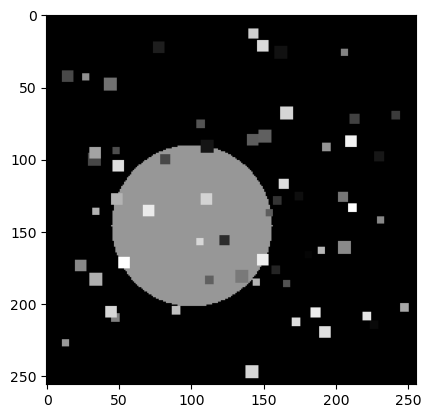

In [145]:
plt.imshow(color_dataset[5]["image"], cmap="gray")